### Problem Statement:

What is the electrical consumption of an individual household? What times are consumption at its peak and its minimum? 

### Data: 
The data contains measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. 

**source:** https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

### Data Preperation:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import category_encoders as ce

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv("Data/household_power_consumption.zip", sep=';', compression='zip', low_memory=False)

In [2]:
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.0
2075255,26/11/2010,20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.0
2075256,26/11/2010,21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0
2075257,26/11/2010,21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.0


In [3]:
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [4]:
#convert to datetime
df['Datetime'] = df['Date'].astype(str).str.cat(df['Time'].astype(str), sep=' ')
df['Datetime'] = pd.to_datetime(df['Datetime'])

#convert categorical to numerical 
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')

In [5]:
df = df.drop(columns=['Date', 'Time'])

In [6]:
df_na = df.dropna(axis = 0)
df_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049280 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Global_active_power    float64       
 1   Global_reactive_power  float64       
 2   Voltage                float64       
 3   Global_intensity       float64       
 4   Sub_metering_1         float64       
 5   Sub_metering_2         float64       
 6   Sub_metering_3         float64       
 7   Datetime               datetime64[ns]
dtypes: datetime64[ns](1), float64(7)
memory usage: 140.7 MB


In [7]:
df_na.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [8]:
df_na.corr(numeric_only=True)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.247017,-0.399762,0.998889,0.484401,0.434569,0.638555
Global_reactive_power,0.247017,1.000000,-0.112246,0.266120,0.123111,0.139231,0.089617
Voltage,-0.399762,-0.112246,1.000000,-0.411363,-0.195976,-0.167405,-0.268172
Global_intensity,0.998889,0.266120,-0.411363,1.000000,0.489298,0.440347,0.626543
Sub_metering_1,0.484401,0.123111,-0.195976,0.489298,1.000000,0.054721,0.102571
Sub_metering_2,0.434569,0.139231,-0.167405,0.440347,0.054721,1.000000,0.080872
Sub_metering_3,0.638555,0.089617,-0.268172,0.626543,0.102571,0.080872,1.000000


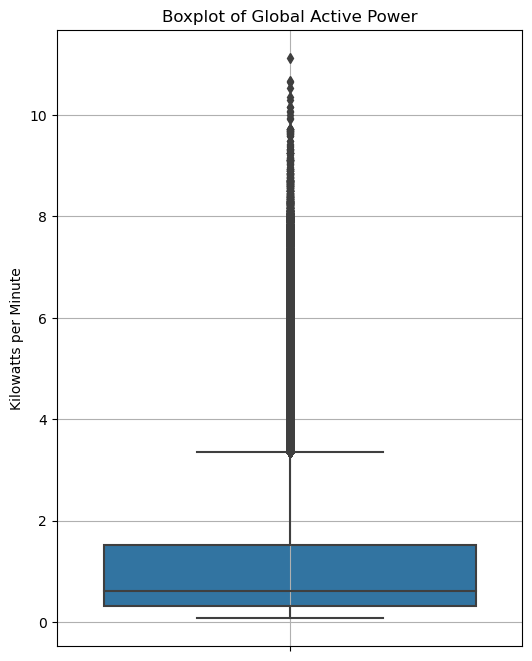

In [9]:
plt.figure(figsize=(6, 8))
sns.boxplot(y=df['Global_active_power'])
plt.title('Boxplot of Global Active Power')
plt.ylabel('Kilowatts per Minute')
plt.grid(True)
plt.show()

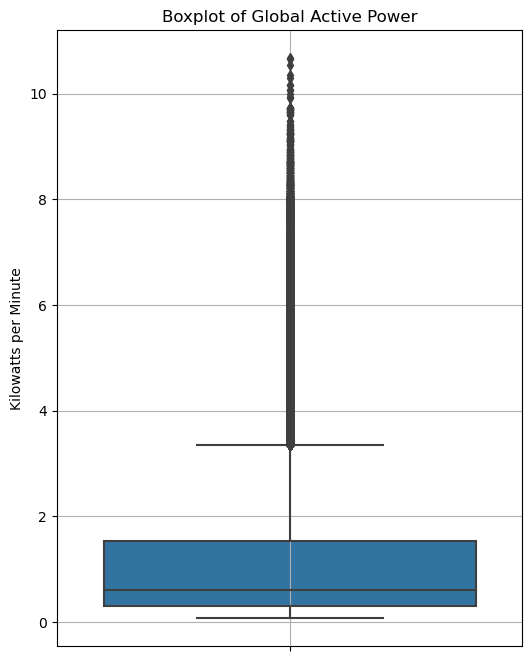

In [10]:
df_na = df_na[df_na['Global_active_power'] < 11] # remove outliers

plt.figure(figsize=(6, 8))
sns.boxplot(y=df_na['Global_active_power'])
plt.title('Boxplot of Global Active Power')
plt.ylabel('Kilowatts per Minute')
plt.grid(True)
plt.show()

In [11]:
df_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049279 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Global_active_power    float64       
 1   Global_reactive_power  float64       
 2   Voltage                float64       
 3   Global_intensity       float64       
 4   Sub_metering_1         float64       
 5   Sub_metering_2         float64       
 6   Sub_metering_3         float64       
 7   Datetime               datetime64[ns]
dtypes: datetime64[ns](1), float64(7)
memory usage: 140.7 MB


### Models

In [12]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

df_reg = df_na.copy()

df_reg['Hour'] = df_na['Datetime'].dt.hour
df_reg['DayOfWeek'] = df_na['Datetime'].dt.dayofweek
df_reg['Month'] = df_na['Datetime'].dt.month
df_reg['IsWeekend'] = df_reg['DayOfWeek'].isin([5,6]).astype(int) #feature engineering to exact more from datetime

X = df_reg.drop(columns = ['Global_active_power', 'Datetime'], axis=1)
y = df_reg['Global_active_power']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size= 0.3)

**Regression**

In [25]:
#pipelines for cleaner implementation 
linear_pipeline = Pipeline([ 
    ('target_encoder', ce.TargetEncoder(cols=['Hour', 'DayOfWeek', 'Month'])), 
    ('scaler', StandardScaler()),   
    ('regressor', LinearRegression())
])

ridge_pipeline = Pipeline([
    ('target_encoder', ce.TargetEncoder(cols=['Hour', 'DayOfWeek', 'Month'])),
    ('scaler', StandardScaler()),   
    ('regressor', Ridge(alpha=1.0))  
])

rf_pipeline = Pipeline([
    ('target_encoder', ce.TargetEncoder(cols=['Hour', 'DayOfWeek', 'Month'])), 
    ('regressor', RandomForestRegressor(n_estimators=50, max_depth=7, random_state=42, n_jobs=-1))
])


In [26]:
linear_pipeline.fit(X_train, y_train)

y_train_pred_lr = linear_pipeline.predict(X_train)
y_test_pred_lr = linear_pipeline.predict(X_test)

rmse_train_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))

print(f" LinearReg Train RMSE: {rmse_train_lr}")
print(f" LinearReg Test  RMSE: {rmse_test_lr}")

 LinearReg Train RMSE: 0.04061517962633067
 LinearReg Test  RMSE: 0.04022226349933515


In [27]:
param_grid = {
    'regressor__alpha': [0.1, 0.5, 1, 3, 5]
}

grid_search = GridSearchCV(estimator=ridge_pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

rmse_train_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f" Best Params: {grid_search.best_params_}")
print(f" RidgeReg Train RMSE: {rmse_train_ridge}")
print(f" RidgeReg Test  RMSE: {rmse_test_ridge}")

 Best Params: {'regressor__alpha': 0.1}
 RidgeReg Train RMSE: 0.04061517962662243
 RidgeReg Test  RMSE: 0.040222263675866315


In [28]:
param_grid = {
    'regressor__n_estimators': [50, 75, 100],
    'regressor__max_depth': [5, 7, 10],
}

grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f" Best Params: {grid_search.best_params_}")
print(f" RandomForestReg Train RMSE: {rmse_train_rf}")
print(f" RandomForestReg Test  RMSE: {rmse_test_rf}")

 Best Params: {'regressor__max_depth': 10, 'regressor__n_estimators': 100}
 RandomForestReg Train RMSE: 0.03449632642483914
 RandomForestReg Test  RMSE: 0.034649879318432684


**Time Series**

In [17]:
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

df_TS = df_reg.copy()
df_TS.set_index('Datetime', inplace=True)

#resample to lower memory requirements and training time
ts = df_TS['Global_active_power'].resample('D').sum().dropna()

ts_boxcox, lambda_value = stats.boxcox(ts[ts > 0])

train_size = int(len(ts_boxcox) * 0.8)
ts_train, ts_test = ts_boxcox[:train_size], ts_boxcox[train_size:]

#check for stationrity
result = adfuller(ts_train, maxlag=10, autolag='AIC')

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -8.002889637659818
p-value: 2.308512352889059e-12


In [18]:
model = pm.auto_arima(ts_train, max_p=4, max_q=4, max_P=3, max_Q=3, seasonal=True, m = 7, stepwise=True)    

In [19]:
forecast = model.predict(n_periods=len(ts_test))
forecast_original = (forecast * lambda_value + 1) ** (1 / lambda_value)

ts_test_original = (ts_test * lambda_value + 1) ** (1 / lambda_value)

ts_rmse = np.sqrt(mean_squared_error(ts_test_original, forecast_original))

print(f"Global Active Power Mean: {ts.mean()}")
print(f"ARIMA RMSE: {ts_rmse}")

Global Active Power Mean: 1535.3560329444065
ARIMA RMSE: 495.0808534346637


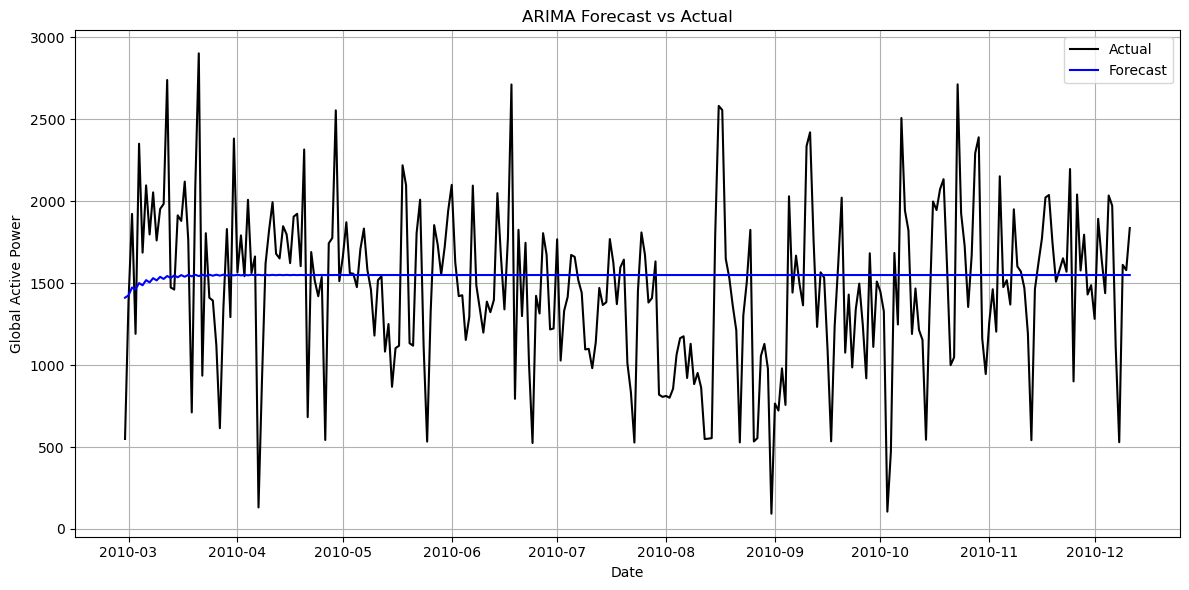

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(ts[ts.index[-len(ts_test_original):]].index, ts_test_original, label='Actual', color='black')
plt.plot(ts[ts.index[-len(forecast_original):]].index, forecast_original, label='Forecast', color='blue')
plt.title(f"ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Global Active Power")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

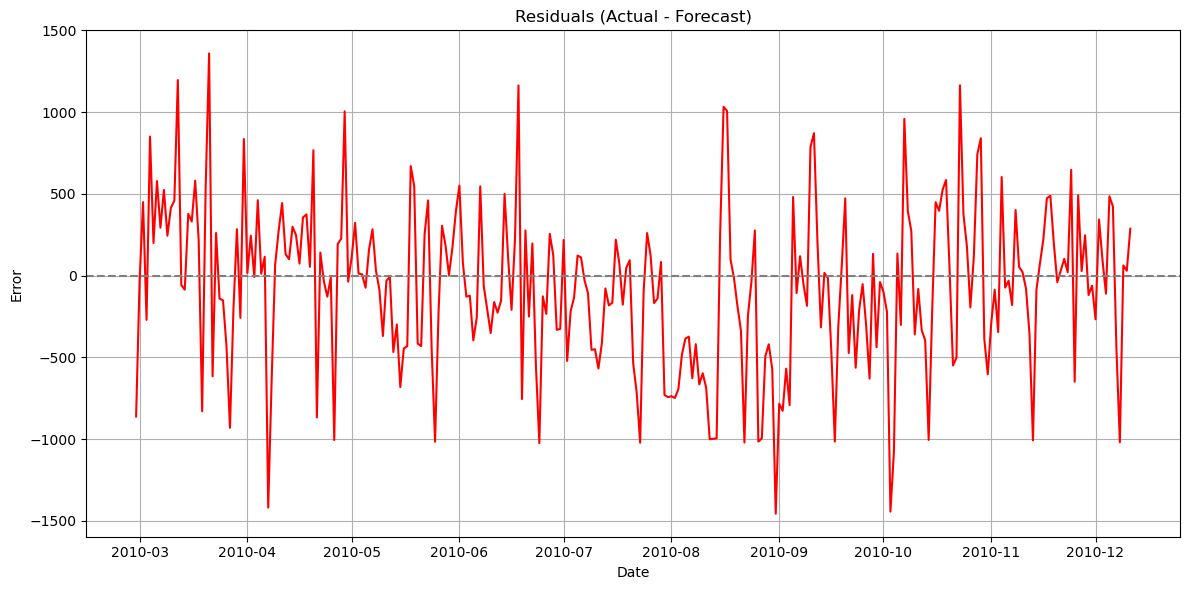

In [21]:
residuals = ts_test_original - forecast_original

plt.figure(figsize=(12, 6))
plt.plot(ts[ts.index[-len(residuals):]].index, residuals, label='Residuals', color='red')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Residuals (Actual - Forecast)")
plt.xlabel("Date")
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
plt.show()

### Exploratory Data Analysis (EDA)

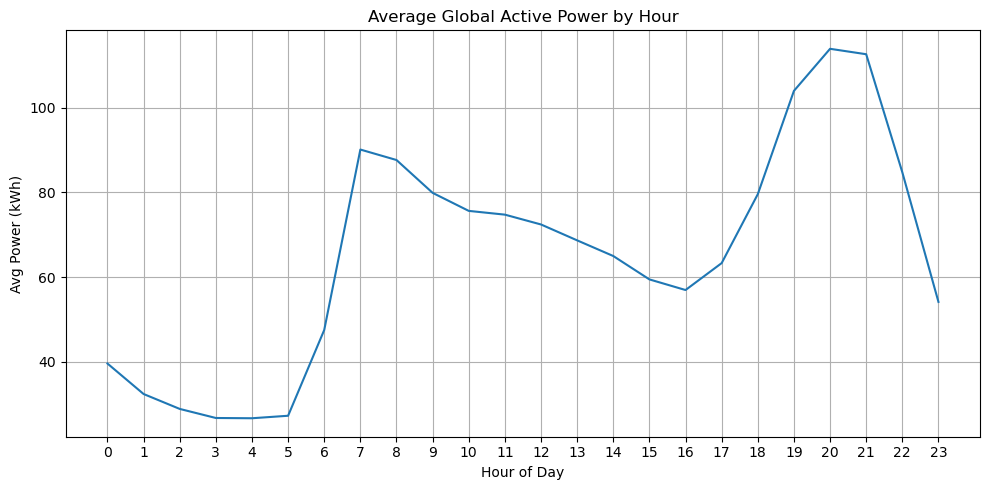

In [22]:
df_peak = df_na.copy()

df_peak['Hour'] = df_na['Datetime'].dt.hour
df_peak['Global_active_power'] = df_na['Global_active_power'] * 60 #Global active power is kW per min
hourly_avg = df_peak.groupby('Hour')['Global_active_power'].mean() #Avg kWh at each hour of day

plt.figure(figsize=(10,5))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values)
plt.title("Average Global Active Power by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Avg Power (kWh)")
plt.xticks(range(24))
plt.grid()
plt.tight_layout()
plt.show()

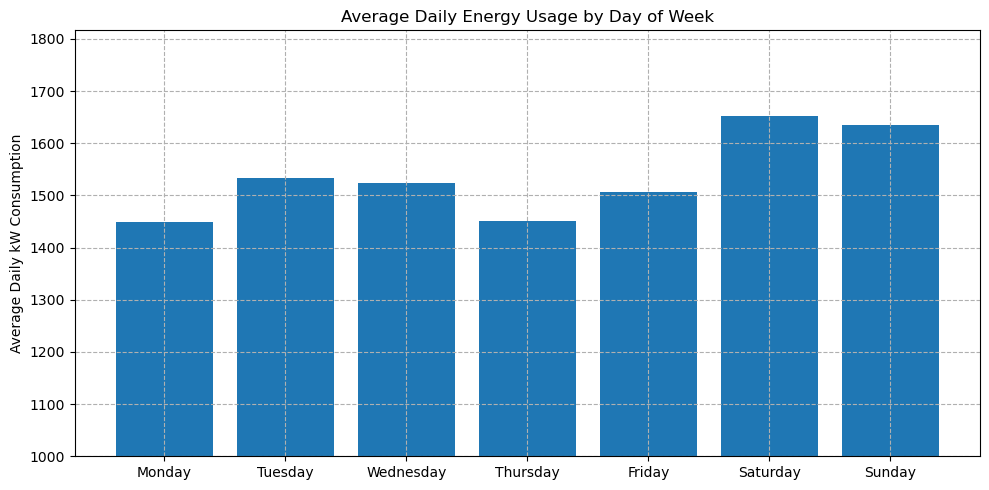

In [23]:
df_day = df_reg.copy()
df_day.set_index('Datetime', inplace=True)
df_daily = df_day['Global_active_power'].resample('D').sum().reset_index() #calculated in kW, resampling to get kW spent each day
df_daily['DayOfWeek'] = df_daily['Datetime'].dt.day_name()

df_dow = df_daily.groupby('DayOfWeek')['Global_active_power'].mean()
df_dow = df_dow.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 5))
plt.bar(df_dow.index, df_dow.values)
plt.title('Average Daily Energy Usage by Day of Week')
plt.ylabel('Average Daily kW Consumption')
plt.ylim(1000, df_dow.values.max() * 1.1)
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()

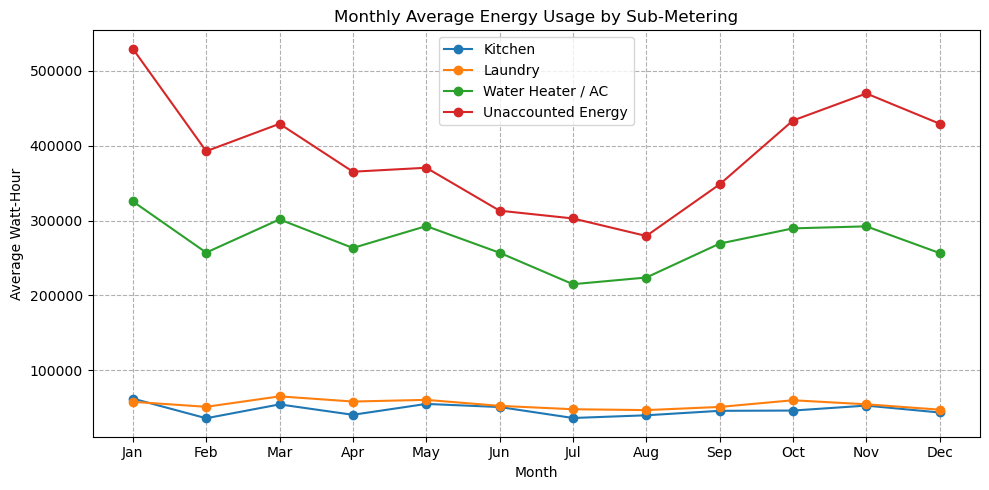

In [24]:
df_month = df_reg.copy()

df_month['YearMonth'] = df_reg['Datetime'].dt.to_period('M')

df_month['Unaccounted_Energy'] = (df_reg['Global_active_power'] * 1000 / 60) \
                                - df_reg['Sub_metering_1'] \
                                - df_reg['Sub_metering_2'] \
                                - df_reg['Sub_metering_3'] 
    #accounts for energy used not read with sub metering

monthly_total_wh = df_month.groupby('YearMonth')[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', \
                                                  'Unaccounted_Energy']].sum() #sums up Wh per month per year

monthly_total_wh['Month'] = monthly_total_wh.index.month
monthly_avg_wh = monthly_total_wh.groupby('Month')[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', \
                                                    'Unaccounted_Energy']].mean() #averages the Wh per month

plt.figure(figsize=(10, 5))
plt.plot(monthly_avg_wh.index, monthly_avg_wh['Sub_metering_1'], marker='o', label='Kitchen')
plt.plot(monthly_avg_wh.index, monthly_avg_wh['Sub_metering_2'], marker='o', label='Laundry')
plt.plot(monthly_avg_wh.index, monthly_avg_wh['Sub_metering_3'], marker='o', label='Water Heater / AC')
plt.plot(monthly_avg_wh.index, monthly_avg_wh['Unaccounted_Energy'], marker='o', label='Unaccounted Energy')


plt.title('Monthly Average Energy Usage by Sub-Metering')
plt.xlabel('Month')
plt.ylabel('Average Watt-Hour')
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.grid(True, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()